### Import Libraries and Data Set

In [1]:

#Import Libraries

import pandas as pd
import math
import matplotlib.pylab as plt
import numpy as np
import statsmodels.api as sm

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import Data Set

bank_df = pd.read_csv('D:/USD-ADS_graduate/ADS-505/ADS505 Final Project/Dataset/bank.csv', sep=';')
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


       1 - age (numeric)
       2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services") 
       3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
       4 - education (categorical: "unknown","secondary","primary","tertiary")
       5 - default: has credit in default? (binary: "yes","no")
       6 - balance: average yearly balance, in euros (numeric) 
       7 - housing: has housing loan? (binary: "yes","no")
       8 - loan: has personal loan? (binary: "yes","no")
       9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
      10 - day: last contact day of the month (numeric)
      11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
      12 - duration: last contact duration, in seconds (numeric)
      13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
      14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
      15 - previous: number of contacts performed before this campaign and for this client (numeric)
      16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

      Output variable (desired target):
      17 - y - has the client subscribed a term deposit? (binary: "yes","no")

### EDA

In [3]:
#Find Number of Columns and Rows in Data Set

bank_df.shape

(4521, 17)

In [4]:
#Find Type of Variables

bank_df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [5]:
#Descriptive Statistics

bank_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [6]:
#Find any missing values

bank_df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

    No missing or null values, OK.

In [7]:
# check positive response

print((bank_df['y'] == 'yes').sum())

# check for response rate

print(100*(bank_df['y'] == 'yes').sum() / len(bank_df))

521
11.523999115239992


    Slightly imblanced dataset, but OK

#### Use histogram  to check for skewness for numeric variables:

Text(0.5, 1.0, 'Frequency of age')

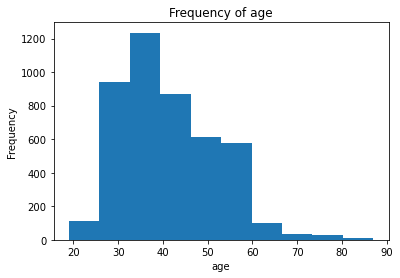

In [8]:
bank_df['age'].plot.hist()
plt.xlabel('age')
plt.title('Frequency of age')

# 

Text(0.5, 1.0, 'Frequency of balance')

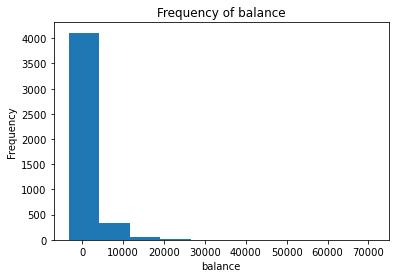

In [9]:
bank_df['balance'].plot.hist()
plt.xlabel('balance')
plt.title('Frequency of balance')

# 

Text(0.5, 1.0, 'last contact day of the month')

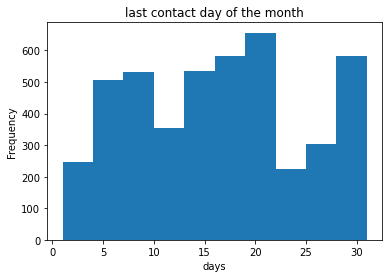

In [10]:
bank_df['day'].plot.hist()
plt.xlabel('days')
plt.title('last contact day of the month')

# 

Text(0.5, 1.0, 'last contact duration (sec)')

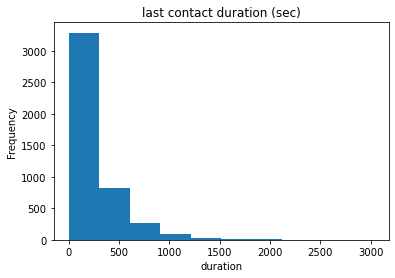

In [11]:
bank_df['duration'].plot.hist()
plt.xlabel('duration')
plt.title('last contact duration (sec)')

# 

Text(0.5, 1.0, 'Number of contact performed before')

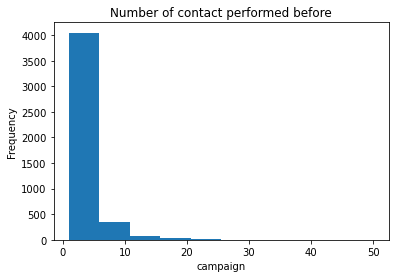

In [12]:
bank_df['campaign'].plot.hist()
plt.xlabel('campaign')
plt.title('Number of contact performed before')

# 

Text(0.5, 1.0, 'number of days that passed by')

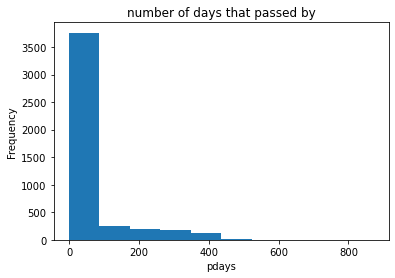

In [13]:
bank_df['pdays'].plot.hist()
plt.xlabel('pdays')
plt.title('number of days that passed by')

# 

Text(0.5, 1.0, 'number of contacts performed')

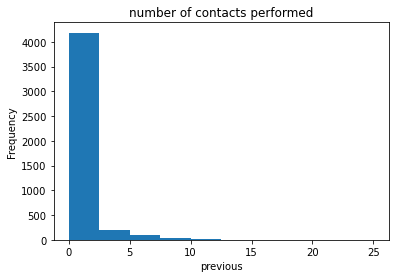

In [14]:
bank_df['previous'].plot.hist()
plt.xlabel('previous')
plt.title('number of contacts performed')

    In order to deal with skewed data (positively skewed for the most part), we'll perform log transformation.
    https://towardsdatascience.com/skewed-data-a-problem-to-your-statistical-model-9a6b5bb74e37
    
    Since Log transformation cannot be applied to zero or negative values, we will leave 'pdays', 'balance', 'previous' out since they contain zero or negative values.

In [15]:
bank_df['duration_log10'] = np.log(bank_df['duration'])
bank_df['campaign_log10'] = np.log(bank_df['campaign'])

Text(0.5, 1.0, 'duration_log10')

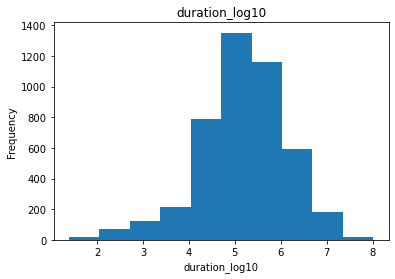

In [16]:
bank_df['duration_log10'].plot.hist()
plt.xlabel('duration_log10')
plt.title('duration_log10')

Text(0.5, 1.0, 'campaign_log10')

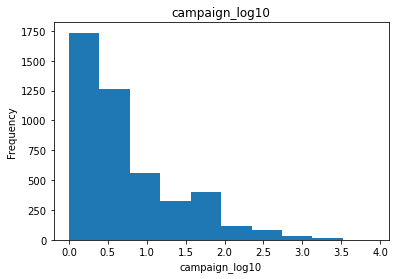

In [17]:
bank_df['campaign_log10'].plot.hist()
plt.xlabel('campaign_log10')
plt.title('campaign_log10')

#### 

In [18]:
bank_df = bank_df.drop(['duration','campaign'], axis = 1)
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,pdays,previous,poutcome,y,duration_log10,campaign_log10
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,-1,0,unknown,no,4.369448,0.000000
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,339,4,failure,no,5.393628,0.000000
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,330,1,failure,no,5.220356,0.000000
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,-1,0,unknown,no,5.293305,1.386294
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,-1,0,unknown,no,5.420535,0.000000


    For categorical/binary features, we will use overlay bar chart to observe the relations of them to y

job            y  
admin.         no     420
               yes     58
blue-collar    no     877
               yes     69
entrepreneur   no     153
               yes     15
housemaid      no      98
               yes     14
management     no     838
               yes    131
retired        no     176
               yes     54
self-employed  no     163
               yes     20
services       no     379
               yes     38
student        no      65
               yes     19
technician     no     685
               yes     83
unemployed     no     115
               yes     13
unknown        no      31
               yes      7
Name: y, dtype: int64


Text(0.5, 1.0, 'y VS. jobs')

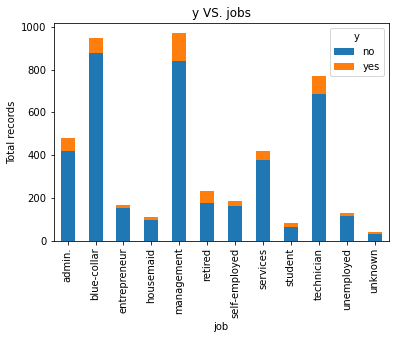

In [19]:
print(bank_df.groupby(['job'])['y'].value_counts())

crosstab_job = pd.crosstab(bank_df['job'], bank_df['y'])
crosstab_job.plot(kind='bar', stacked = True)
plt.ylabel("Total records")
plt.title('y VS. jobs')

marital   y  
divorced  no      451
          yes      77
married   no     2520
          yes     277
single    no     1029
          yes     167
Name: y, dtype: int64


Text(0.5, 1.0, 'y VS. marital')

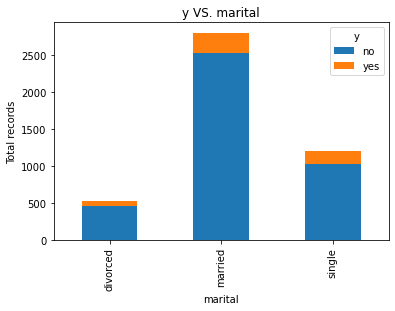

In [20]:
print(bank_df.groupby(['marital'])['y'].value_counts())

crosstab_marital = pd.crosstab(bank_df['marital'], bank_df['y'])
crosstab_marital.plot(kind='bar', stacked = True)
plt.ylabel("Total records")
plt.title('y VS. marital')

education  y  
primary    no      614
           yes      64
secondary  no     2061
           yes     245
tertiary   no     1157
           yes     193
unknown    no      168
           yes      19
Name: y, dtype: int64


Text(0.5, 1.0, 'y VS. education')

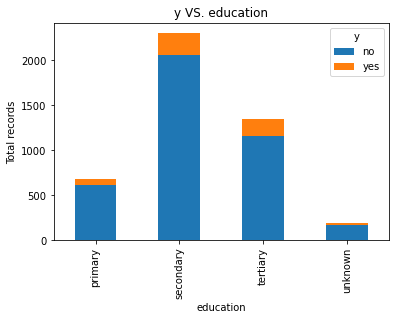

In [21]:
print(bank_df.groupby(['education'])['y'].value_counts())

crosstab_education = pd.crosstab(bank_df['education'], bank_df['y'])
crosstab_education.plot(kind='bar', stacked = True)
plt.ylabel("Total records")
plt.title('y VS. education')

default  y  
no       no     3933
         yes     512
yes      no       67
         yes       9
Name: y, dtype: int64


Text(0.5, 1.0, 'y VS. default')

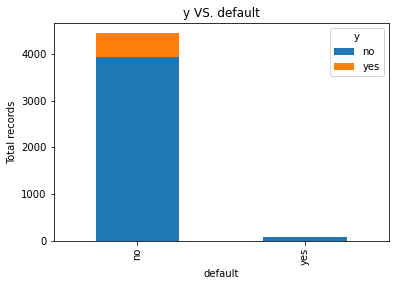

In [22]:
print(bank_df.groupby(['default'])['y'].value_counts())

crosstab_default = pd.crosstab(bank_df['default'], bank_df['y'])
crosstab_default.plot(kind='bar', stacked = True)
plt.ylabel("Total records")
plt.title('y VS. default')

    The ' default' feature is heavily imblanced, using this variable may introduce biases. Decided to drop this feature.

In [23]:
bank_df = bank_df.drop(['default'], 1)

#### 

housing  y  
no       no     1661
         yes     301
yes      no     2339
         yes     220
Name: y, dtype: int64


Text(0.5, 1.0, 'y VS. housing')

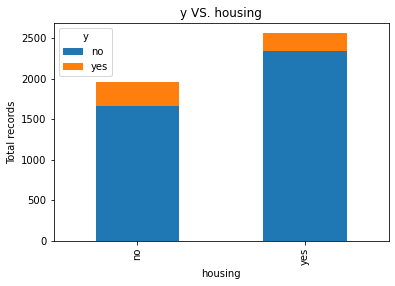

In [24]:
print(bank_df.groupby(['housing'])['y'].value_counts())

crosstab_housing = pd.crosstab(bank_df['housing'], bank_df['y'])
crosstab_housing.plot(kind='bar', stacked = True)
plt.ylabel("Total records")
plt.title('y VS. housing')

loan  y  
no    no     3352
      yes     478
yes   no      648
      yes      43
Name: y, dtype: int64


Text(0.5, 1.0, 'y VS. loan')

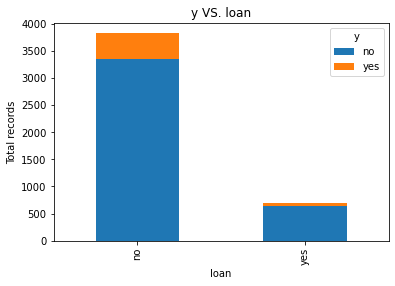

In [25]:
print(bank_df.groupby(['loan'])['y'].value_counts())

crosstab_loan = pd.crosstab(bank_df['loan'], bank_df['y'])
crosstab_loan.plot(kind='bar', stacked = True)
plt.ylabel("Total records")
plt.title('y VS. loan')

contact    y  
cellular   no     2480
           yes     416
telephone  no      257
           yes      44
unknown    no     1263
           yes      61
Name: y, dtype: int64


Text(0.5, 1.0, 'y VS. contact')

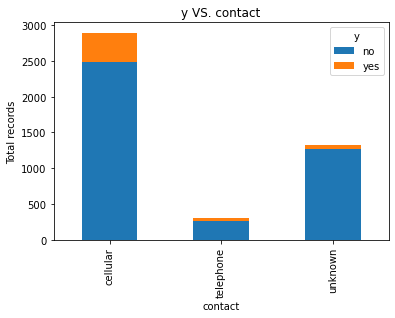

In [26]:
print(bank_df.groupby(['contact'])['y'].value_counts())

crosstab_contact = pd.crosstab(bank_df['contact'], bank_df['y'])
crosstab_contact.plot(kind='bar', stacked = True)
plt.ylabel("Total records")
plt.title('y VS. contact')

contact    y  
cellular   no     2480
           yes     416
telephone  no      257
           yes      44
unknown    no     1263
           yes      61
Name: y, dtype: int64


Text(0.5, 1.0, 'y VS. contact')

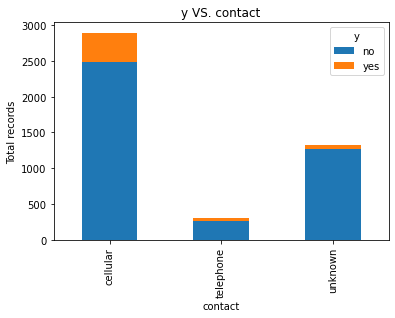

In [27]:
print(bank_df.groupby(['contact'])['y'].value_counts())

crosstab_contact = pd.crosstab(bank_df['contact'], bank_df['y'])
crosstab_contact.plot(kind='bar', stacked = True)
plt.ylabel("Total records")
plt.title('y VS. contact')

day  y  
1    no      17
     yes     10
2    no     100
     yes     14
3    no      93
           ... 
29   yes     10
30   no     141
     yes     27
31   no      55
     yes      4
Name: y, Length: 62, dtype: int64


Text(0.5, 1.0, 'y VS. day')

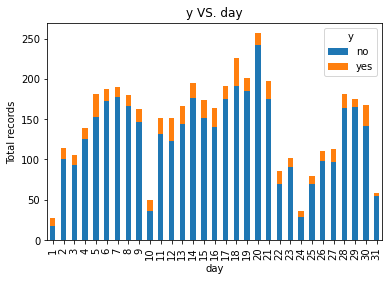

In [28]:
print(bank_df.groupby(['day'])['y'].value_counts())

crosstab_day = pd.crosstab(bank_df['day'], bank_df['y'])
crosstab_day.plot(kind='bar', stacked = True)
plt.ylabel("Total records")
plt.title('y VS. day')

    From the bar chart we can see that the 'day' categorizes three clusters, so we can change the 'day' into a 3-classes categorical variable. 

In [29]:
b = [1,10,20,30]
l = ['Early-month','Mid-month','Late-month']

bank_df['day'] = pd.cut(bank_df['day'], bins=b, labels=l, include_lowest=True) # replace 'day' with new labels

#### 

month  y  
apr    no      237
       yes      56
aug    no      554
       yes      79
dec    no       11
       yes       9
feb    no      184
       yes      38
jan    no      132
       yes      16
jul    no      645
       yes      61
jun    no      476
       yes      55
mar    no       28
       yes      21
may    no     1305
       yes      93
nov    no      350
       yes      39
oct    no       43
       yes      37
sep    no       35
       yes      17
Name: y, dtype: int64


Text(0.5, 1.0, 'y VS. month')

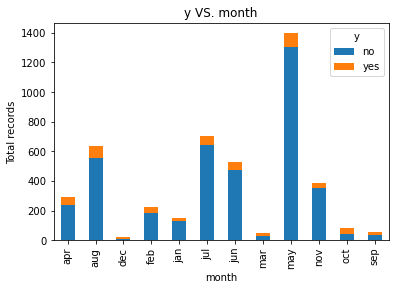

In [30]:
print(bank_df.groupby(['month'])['y'].value_counts())

crosstab_month = pd.crosstab(bank_df['month'], bank_df['y'])
crosstab_month.plot(kind='bar', stacked = True)
plt.ylabel("Total records")
plt.title('y VS. month')

poutcome  y  
failure   no      427
          yes      63
other     no      159
          yes      38
success   yes      83
          no       46
unknown   no     3368
          yes     337
Name: y, dtype: int64


Text(0.5, 1.0, 'y VS. poutcome')

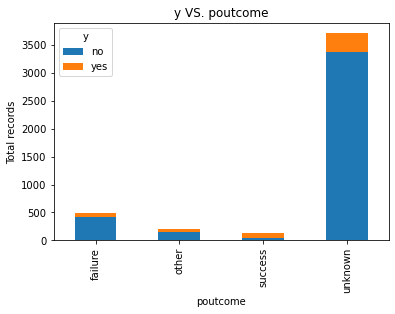

In [31]:
print(bank_df.groupby(['poutcome'])['y'].value_counts())

crosstab_poutcome = pd.crosstab(bank_df['poutcome'], bank_df['y'])
crosstab_poutcome.plot(kind='bar', stacked = True)
plt.ylabel("Total records")
plt.title('y VS. poutcome')

#### 

    For 'pdays', we only care about whether a client was last contacted from a previous campaign or not. So we will convert '-1' to '0' and any other value to '1'

pdays
0    3705
1     816
Name: y, dtype: int64


Text(0.5, 1.0, 'y VS. pdays')

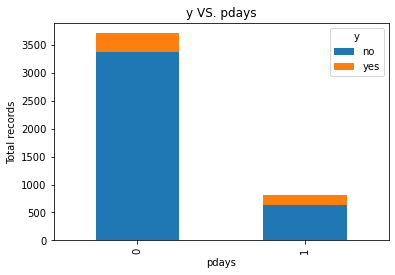

In [32]:
b = [-1,0,99999]
l = ['0','1']

bank_df['pdays'].astype(int)
bank_df['pdays'] = pd.cut(bank_df['pdays'], bins=b, labels=l, include_lowest=True)

print(bank_df.groupby(['pdays'])['y'].count())

crosstab_pdays = pd.crosstab(bank_df['pdays'], bank_df['y'])
crosstab_pdays.plot(kind='bar', stacked = True)
plt.ylabel("Total records")
plt.title('y VS. pdays')

In [33]:
# normalize the numeric values

bank_df['balance_norm'] = StandardScaler().fit_transform(bank_df[['balance']])
bank_df['age_norm'] = StandardScaler().fit_transform(bank_df[['age']])

bank_df = bank_df.drop(['balance'],1)
bank_df = bank_df.drop(['age'],1)

In [34]:
# convert 'y' from 'yes' and 'no' to '1' and '0'
bank_df['y'] = bank_df['y'].map(dict(yes=1, no=0))

# convert 'housing' from 'yes' and 'no' to '1' and '0'
bank_df['housing'] = bank_df['housing'].map(dict(yes=1, no=0))

# convert 'load' from 'yes' and 'no' to '1' and '0'
bank_df['loan'] = bank_df['loan'].map(dict(yes=1, no=0))

# check for the positive response
print(bank_df['y'].tolist().count(1))

bank_df.head()

521


,job,marital,education,housing,loan,contact,day,month,pdays,previous,poutcome,y,duration_log10,campaign_log10,balance_norm,age_norm
0,unemployed,married,primary,0,0,cellular,Mid-month,oct,0,0,unknown,0,4.369448,0.000000,0.121072,-1.056270
1,services,married,secondary,1,1,cellular,Mid-month,may,1,4,failure,0,5.393628,0.000000,1.118644,-0.772583
2,management,single,tertiary,1,0,cellular,Mid-month,apr,1,1,failure,0,5.220356,0.000000,-0.024144,-0.583458
3,management,married,tertiary,1,1,unknown,Early-month,jun,0,0,unknown,0,5.293305,1.386294,0.017726,-1.056270
4,blue-collar,married,secondary,1,0,unknown,Early-month,may,0,0,unknown,0,5.420535,0.000000,-0.472753,1.686036


In [35]:
# convert objects to categorical

#bank_df['job'] = bank_df['job'].astype('category')
#bank_df['marital'] = bank_df['marital'].astype('category')
#bank_df['education'] = bank_df['education'].astype('category')
#bank_df['contact'] = bank_df['contact'].astype('category')
#bank_df['month'] = bank_df['month'].astype('category')
#bank_df['poutcome'] = bank_df['poutcome'].astype('category')
#bank_df.dtypes

In [36]:
bank_df['job'] = bank_df['job'].replace({'management': 'Employed', 'blue-collar': 'Employed',
                                 'technician': 'Employed', 'admin.': 'Employed',
                                 'services': 'Employed', 'retired': 'Unemployed',
                                 'self-employed': 'Self-employed', 'entrepreneur':'Employed',
                                 'unemployed': 'Unemployed', 'housemaid': 'Employed',
                                 'student': 'Unemployed', 'unknown': 'Employed'})

bank_df['job'].value_counts()

Employed         3896
Unemployed        442
Self-employed     183
Name: job, dtype: int64

In [37]:
# create dummy variables for categorical features

cat_df = bank_df[['job','marital','education','contact','day','month','poutcome']]
dummy_df = pd.get_dummies(cat_df)

# merge dummy variables to the original bank_df

bank_df = pd.concat([bank_df, dummy_df], axis=1)  

# drop the original categorical features

bank_df = bank_df.drop(['job','marital','education','contact','day','month','poutcome'], axis = 1)
bank_df

,housing,loan,pdays,previous,y,duration_log10,campaign_log10,balance_norm,age_norm,job_Employed,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,0,0,0,0,4.369448,0.000000,0.121072,-1.056270,0,...,0,0,0,0,1,0,0,0,0,1
1,1,1,1,4,0,5.393628,0.000000,1.118644,-0.772583,1,...,0,0,1,0,0,0,1,0,0,0
2,1,0,1,1,0,5.220356,0.000000,-0.024144,-0.583458,1,...,0,0,0,0,0,0,1,0,0,0
3,1,1,0,0,0,5.293305,1.386294,0.017726,-1.056270,1,...,1,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,5.420535,0.000000,-0.472753,1.686036,1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,1,0,0,0,0,5.796058,1.609438,-0.583410,-0.772583,1,...,0,0,0,0,0,0,0,0,0,1
4517,1,1,0,0,0,5.030438,0.000000,-1.573671,1.496912,0,...,0,0,1,0,0,0,0,0,0,1
4518,0,0,0,0,0,5.017280,2.397895,-0.374724,1.496912,1,...,0,0,0,0,0,0,0,0,0,1
4519,0,0,1,3,0,4.859812,1.386294,-0.094925,-1.245394,1,...,0,0,0,0,0,0,0,1,0,0
